# Datenaufbereitung - Vorgehen
Dieses Dokument beschreibt den Prozess der Datenaufbereitung vom Laden aus der MongoDB bis zum exportieren der Trainingsdatensätze als csv.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import copy
import importbib

## Herunterladen der Daten aus der MongoDB
Als erstes werden die Daten für einen bestimmten Zeitabschnitt über die Funktion loadTimeframeFromMongoDB heruntergeladen. Start- und Endzeitpunkt des Reibvorgans müssen in etwa bekannt sein. Der angegebene Zeitrahmen muss größer gewählt werden, sodass auf jeden Fall alle Reibdaten enthalten sind. **Achtung**: Während dem Download muss der entsprechende Rechner im VPN der Hochschule sein.

In [ ]:
dtStart = datetime(2019,11,26,12,0)
dtEnd = datetime(2019,11,26,23,59)
dfTimeFrame = importbib.loadTimeframeFromMongoDB(dtStart,dtEnd)
dfTimeFrame.to_csv("csv_Files/2019-11-26_VALUES_EXPORT.csv", index=False, sep=",", encoding="utf-8")

Bereits heruntergeladene Daten können über die normale Pandasfunktion read_csv gelesen werden. Timestampfelder müssen dann aber noch umgewandelt werden:

In [6]:
dfTimeFrame = pd.read_csv("csv_Files/2019-11-26_VALUES_EXPORT.csv", encoding="utf-8")
dfTimeFrame.timeStamp = pd.to_datetime(dfTimeFrame.timeStamp)
dfTimeFrame.dtypes

_id                  object
ValueID              object
value               float64
timeStamp    datetime64[ns]
dtype: object

Zur visuellen Kontrolle können die Daten der Z-Achse, und die Logdaten weiterer Komponenten geplottet werden. Dazu steht die Hilfsfunktion plotSpecificIDs bereit:

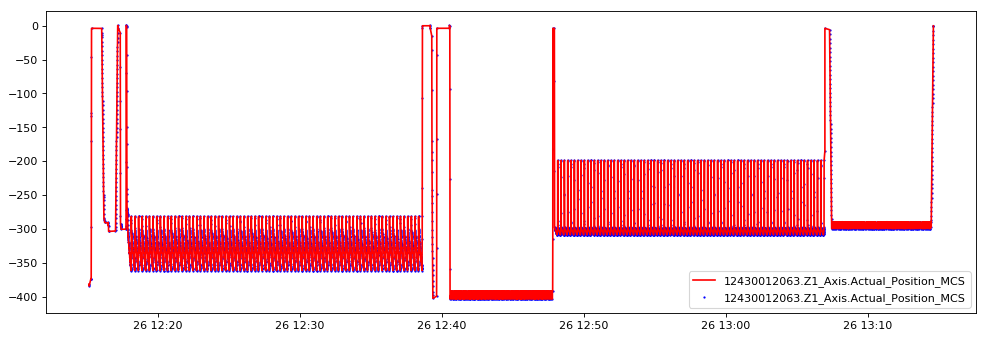

In [7]:
importbib.plotActualZ1(dfTimeFrame, saveFile=False)

In diesem Zeitabschnitt sind neben dem Reiben auch bohren und entgraten zu sehen. Um diesen Vorgang eindeutig von den Anderen unterscheiden zu können, benötigen wir die Daten aus MongoDB-Collection values_ncprogram. Mithilfe der importbib können diese einfach von der MongoDB geladen werden. **Achtung**: Während dem Download muss der entsprechende Rechner im VPN der Hochschule sein.

In [9]:
dtStart = datetime(2019,11,26,12,0)
dtEnd = datetime(2019,11,26,23,59)
dfReibdaten = importbib.loadReibdatenFromMongoDB(dtStart,dtEnd)
dfReibdaten.to_csv("csv_Files/2019-11-26_NCPROGRAM_EXPORT.csv", index=False, sep=",", encoding="utf-8")
dfReibdaten.head()

0, 10000, 

,_id,ValueID,value,timeStamp,progName,toolNo
0,5ddd1ea38e15b3086c06b050,12430012063.Channel1.Feed_Axis,40000.000000,2019-11-26 12:47:47.857,REIBEN.MPF,RA_12H7
1,5ddd1ea38e15b3086c06b056,12430012063.Channel1.Program_Feed,40000.000000,2019-11-26 12:47:47.870,REIBEN.MPF,RA_12H7
2,5ddd1ea38e15b3086c06b057,12430012063.Channel1.Spindle_Speed,0.000000,2019-11-26 12:47:47.871,REIBEN.MPF,RA_12H7
3,5ddd1ea38e15b3086c06b067,12430012063.Channel1.Feed_Axis,12864.037984,2019-11-26 12:47:47.949,REIBEN.MPF,RA_12H7
4,5ddd1ea38e15b3086c06b068,12430012063.Channel1.Program_Feed,12864.037984,2019-11-26 12:47:47.953,REIBEN.MPF,RA_12H7


Plottet man nun Z-Achsendaten und Reibdaten in den gleichen Plot, so sieht man, wann die Reibe aktiv war:

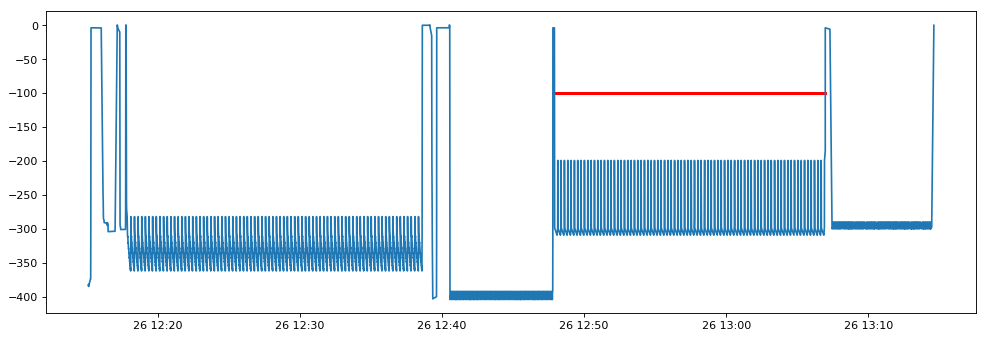

In [15]:

fig = plt.figure(figsize=(15, 5), dpi=80)
zAxisData = dfTimeFrame.loc[lambda l: l['ValueID'] == "12430012063.Z1_Axis.Actual_Position_MCS",:]
plt.plot(zAxisData.timeStamp,zAxisData.value)
plt.scatter(dfReibdaten.timeStamp,[-100]*len(dfReibdaten), s=1.0,c='r')

Wir speichern diesen Bereich des Datensatzes nun in einem einem eigenen DataFrame ab. Dafür existiert die Funktion approxRangeInSteps, die einen kleinen Zeitraum innerhalb des Vorgangs entgegennimmt (hier z.b. 12:55 Uhr - 13 Uhr, der *Samplezeitraum*), minimum und maximum des Z-Achsenwertes misst, und dann versucht, den größten Bereich zu finden, in dem der Z-Achsenwert diese Werte nicht unter- bzw. überschreitet.

-313.95
-193.95
2019-11-26 12:47:55
2019-11-26 13:06:58


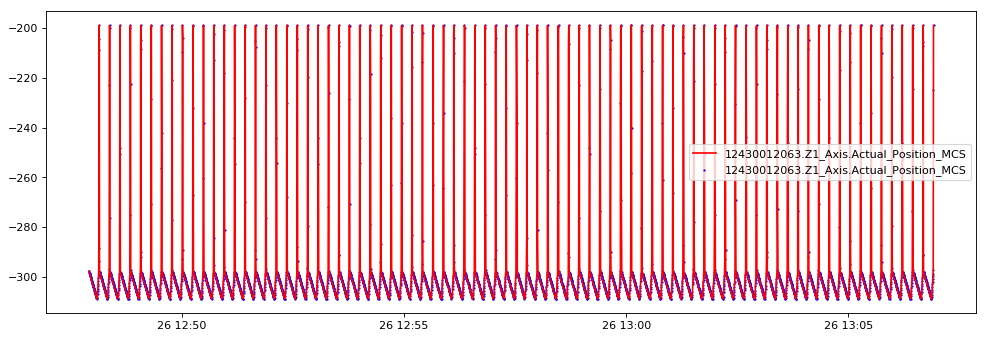

In [19]:
dtSampleStart = datetime(2019,11,26,12,55)
dtSampleEnd = datetime(2019,11,26,13,0)

dtNewStart,dtNewEnd = importbib.approxRangeInSteps(dfTimeFrame,dtSampleStart,dtSampleEnd)
print(str(dtNewStart))
print(str(dtNewEnd))
dfEineEbene = dfTimeFrame.loc[lambda l: ((dtNewStart <= l.timeStamp) & (l.timeStamp <= dtNewEnd)),:]
importbib.plotActualZ1(dfEineEbene, saveFile=False)

Nun müssen die Daten nach den einzelnen Löcher getrennt werden. Hierfür werden die höchsten Z-Achsenwerte hergenommen:

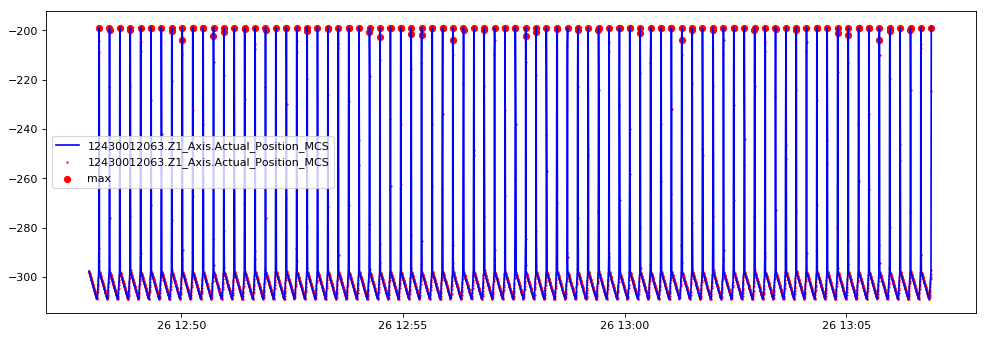

Anzahl der gefundenen Spitzen: 134


In [29]:
top = dfEineEbene.loc[lambda l: l.ValueID == "12430012063.Z1_Axis.Actual_Position_MCS","value"].max()
tolerance = 5.0
topMostPoints = dfEineEbene.loc[lambda l: ((l.ValueID == "12430012063.Z1_Axis.Actual_Position_MCS") & (top-tolerance < l.value) & (l.value < top+tolerance)),:]


fig = plt.figure(figsize=(15, 5), dpi=80)
zAxisEineEbene = dfEineEbene.loc[lambda l: l.ValueID == "12430012063.Z1_Axis.Actual_Position_MCS",:]
plt.plot(zAxisEineEbene.timeStamp,zAxisEineEbene.value, c='b')
plt.scatter(zAxisEineEbene.timeStamp,zAxisEineEbene.value,c='r',s=1)
plt.scatter(topMostPoints["timeStamp"], topMostPoints["value"], c='r',s=30)

plt.legend(["12430012063.Z1_Axis.Actual_Position_MCS","12430012063.Z1_Axis.Actual_Position_MCS", "max"])
plt.show()
print("Anzahl der gefundenen Spitzen: "+str(len(topMostPoints)))

Aus dem Diagramm folgt: Wir möchten am Ende 81 Spitzen gefunden haben (9x9 Löcher). Zusammen mit dem Start können wir so 81 Datensätze aggregieren. Genau eine Spitze pro Loch zu finden erfordert nun verschiedene Versuche, die auch variieren können:

In [32]:
# Versuch über die Steigung: ist die Steigung links des Punktes positiv, und rechts davon negativ, so handelt es sich um eine Spitze
dfTops = pd.DataFrame()
for i in range(1,zAxisEineEbene.shape[0]-1):
    diff1 = zAxisEineEbene.iloc[i].value - zAxisEineEbene.iloc[i-1].value # muss positiv sein
    diff2 = zAxisEineEbene.iloc[i].value - zAxisEineEbene.iloc[i+1].value # muss auch positiv sein
    if diff1 > 0 and diff2 > 0:
        dfTops = dfTops.append(zAxisEineEbene.iloc[i])
print(len(dfTops))

80


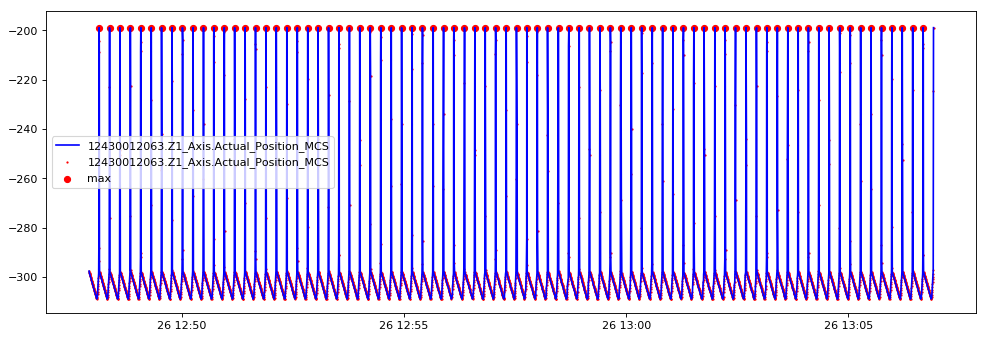

In [33]:
fig = plt.figure(figsize=(15, 5), dpi=80)
zAxisEineEbene = dfEineEbene.loc[lambda l: l.ValueID == "12430012063.Z1_Axis.Actual_Position_MCS",:]
plt.plot(zAxisEineEbene.timeStamp,zAxisEineEbene.value, c='b')
plt.scatter(zAxisEineEbene.timeStamp,zAxisEineEbene.value,c='r',s=1)
plt.scatter(dfTops.timeStamp, dfTops.value, c='r',s=30)

plt.legend(["12430012063.Z1_Axis.Actual_Position_MCS","12430012063.Z1_Axis.Actual_Position_MCS", "max"])
plt.show()

Der letzte und der erste Punkt müssen manuell hinzugefügt werden

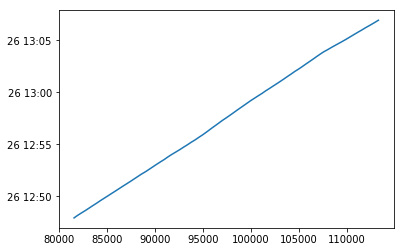

82


In [37]:
dfTops = dfTops.append(zAxisEineEbene.iloc[0])
dfTops = dfTops.append(zAxisEineEbene.iloc[-1])
dfTops = dfTops.sort_values(by="timeStamp")
plt.plot(dfTops.timeStamp)
plt.show()
print(len(dfTops))

Nachdem nun die Korrekte Anzahl an Löchern gefunden wurde, und die Timestamps entsprechend sortiert sind, kann eine Schleife die Daten Pro Loch generieren. Dieser Algorithmus kann noch erweitert werden, je nach dem, welche Daten erfasst werden sollen. Anschließend wird eine Label-Spalte hinzugefügt, die im nächsten Schritt befüllt wird.

In [45]:
ls = []
for start,end in zip(dfTops.iloc[:-1,:].timeStamp,dfTops.iloc[1:,:].timeStamp):
    curData = dfTimeFrame.loc[lambda l: ((start <= l.timeStamp) & (l.timeStamp <= end)),["ValueID","value","timeStamp"]]
    curData = curData.groupby(by="ValueID", as_index=False).mean().T
    curData.columns = curData.iloc[0]
    curData.drop(curData.index[0], inplace=True)
    curData["timeStamp"] = start
    ls.append(curData)
dfData = pd.concat(ls, ignore_index=True, sort=False)
dfData.sort_values(by=["timeStamp"], inplace=True)
dfData["Label"] = "-"
dfData.head()

,12430012063.A1_Axis.Actual_Power,12430012063.Energy_Savings.Active_Power_Spindle1,12430012063.Energy_Savings.Active_Power_Z1,12430012063.Main_Spindle.Actual_Position_MCS,12430012063.Main_Spindle.Actual_Power,12430012063.Main_Spindle.Actual_Speed_Rate,12430012063.Main_Spindle.MPC_Peak,12430012063.Main_Spindle.MPC_Veff_Total,12430012063.Tool_Control_Center.Axial_Force_Tension,12430012063.Tool_Control_Center.Bending_Moment,...,12430012063.X1_Axis.Actual_Feed_Rate,12430012063.X1_Axis.Actual_Position_MCS,12430012063.Main_Spindle.Temperature_Spindle,12430012063.Maintenance_Package.Tool_Usage_Main_lubriTOOL,12430012063.Tool_Control_Center.Axial_Force_Compression,12430012063.Y1_Axis.Actual_Feed_Rate,12430012063.Y1_Axis.Temperature_Y_Slide,12430012063.Energy_Savings.Active_Power_Y1,12430012063.Y1_Axis.Actual_Position_MCS,Label
0,5.5,14.8703,502.046,180.069,0.5,317.278,1.5,0.5,0.361111,2.33333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-
1,5.5,8.71587,283.181,173.267,0.527778,317.19,1,1,0.713636,2.5,...,2096,365.145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-
2,5.5,3.19585,-110.47,173.55,0.5,317.235,2.28571,1,0.38,0.785714,...,4464,376.19,28.3336,72.8,0.0777778,NaN,NaN,NaN,NaN,-
3,5.6,7.66992,115.169,179.416,0.52381,317.5,1.33333,1,0.06,0.5,...,1440,389.29,NaN,NaN,0.0666667,NaN,NaN,NaN,NaN,-
4,5.33333,13.4934,494.246,182.208,0.512821,317.231,1.5,1,0.0333333,0.5,...,242.5,411.655,28.2933,NaN,0.1,NaN,NaN,NaN,NaN,-


Nun muss das entsprechende Messprotokoll geladen und die eingereichtete Spalte damit befüllt werden.

In [10]:
# Einlesen der Daten des Messprotokolls
dfMeas = importbib.importMeasurementData('csv_Files/MEAS_PROTOCOL_CSV_E1.CSV')
dfMeas.head(10)
# print(dfAchs.shape)

,Date,Time,Program,Workpiece no.,Testpoint,Plane,Probe no.,Cycle,S_MVAR,Measuring variant,Results:,Setpoint,Measured,Difference,Unit
0,2019-11-20,12:14:13,REIBEN.MPF,,1,G17,1,977,1,1 Hole,X,"15,000","14,976","-0,024",mm
1,2019-11-20,12:14:13,REIBEN.MPF,,1,G17,1,977,1,1 Hole,Y,"15,000","15,016","0,016",mm
2,2019-11-20,12:14:13,REIBEN.MPF,,1,G17,1,977,1,1 Hole,Diameter,"12,009","12,019","0,010",mm
3,2019-11-20,12:14:18,REIBEN.MPF,,1,G17,1,977,1,1 Hole,X,"30,000","29,994","-0,006",mm
4,2019-11-20,12:14:18,REIBEN.MPF,,1,G17,1,977,1,1 Hole,Y,"15,000","14,986","-0,014",mm
5,2019-11-20,12:14:18,REIBEN.MPF,,1,G17,1,977,1,1 Hole,Diameter,"12,009","12,018","0,009",mm
6,2019-11-20,12:14:23,REIBEN.MPF,,1,G17,1,977,1,1 Hole,X,"45,000","44,979","-0,021",mm
7,2019-11-20,12:14:23,REIBEN.MPF,,1,G17,1,977,1,1 Hole,Y,"15,000","14,997","-0,003",mm
8,2019-11-20,12:14:23,REIBEN.MPF,,1,G17,1,977,1,1 Hole,Diameter,"12,009","12,015","0,006",mm
9,2019-11-20,12:14:28,REIBEN.MPF,,1,G17,1,977,1,1 Hole,X,"60,000","59,997","-0,003",mm


In [11]:
# Einlesen der Daten der Achsleistung
dfAchs = importbib.importAchsleistungsData('csv_Files/Achsleistung-2019-11-20T10-27-03_E1.csv')
dfAchs.head(10)
# print(dfAchs.shape)

,Timestamp,X1,Y1,Z1,C1,A1,SPI1,WZM,X1 (mech),Y1 (mech),Z1 (mech),C1 (mech),A1 (mech),SPI1 (mech),WZM (mech)
0,"2019-11-20T10:27:03,117",232.660,211.220,3145.891,313.976,1496.938,1761.312,0.0,0.0,0.0,3993.138,0.0,0.0,460.194,0.0
1,"2019-11-20T10:27:03,127",232.660,215.914,3148.384,317.148,1493.766,1193.998,0.0,0.0,0.0,3993.138,0.0,0.0,460.194,0.0
2,"2019-11-20T10:27:03,129",232.660,215.914,3148.384,317.148,1493.766,1193.998,0.0,0.0,0.0,0.000,0.0,0.0,479.369,0.0
3,"2019-11-20T10:27:03,139",230.884,220.608,3148.384,307.633,1493.766,705.844,0.0,0.0,0.0,0.000,0.0,0.0,479.369,0.0
4,"2019-11-20T10:27:03,141",230.884,220.608,3148.384,307.633,1493.766,705.844,0.0,0.0,0.0,0.000,0.0,0.0,383.495,0.0
5,"2019-11-20T10:27:03,320",234.436,215.914,3148.384,294.947,1490.595,1398.495,0.0,0.0,0.0,0.000,0.0,0.0,383.495,0.0
6,"2019-11-20T10:27:03,321",234.436,215.914,3148.384,294.947,1490.595,1398.495,0.0,0.0,0.0,0.000,0.0,0.0,766.990,0.0
7,"2019-11-20T10:27:03,517",232.660,218.261,3160.847,275.919,1493.766,1517.235,0.0,0.0,0.0,0.000,0.0,0.0,766.990,0.0
8,"2019-11-20T10:27:03,519",232.660,218.261,3160.847,275.919,1493.766,1517.235,0.0,0.0,0.0,0.000,0.0,0.0,843.689,0.0
9,"2019-11-20T10:27:03,717",232.660,211.220,3155.862,266.404,1487.423,2025.179,0.0,0.0,0.0,0.000,0.0,0.0,843.689,0.0


In [14]:
# Zusammenführen beider Datenquellen // sinnvoll?
dfResult = pd.concat([dfMeas, dfAchs], axis=1)
dfResult.head()
# print(dfResult.shape)

,Date,Time,Program,Workpiece no.,Testpoint,Plane,Probe no.,Cycle,S_MVAR,Measuring variant,...,A1,SPI1,WZM,X1 (mech),Y1 (mech),Z1 (mech),C1 (mech),A1 (mech),SPI1 (mech),WZM (mech)
0,2019-11-20,12:14:13,REIBEN.MPF,,1.0,G17,1.0,977.0,1.0,1 Hole,...,1496.938,1761.312,0.0,0.0,0.0,3993.138,0.0,0.0,460.194,0.0
1,2019-11-20,12:14:13,REIBEN.MPF,,1.0,G17,1.0,977.0,1.0,1 Hole,...,1493.766,1193.998,0.0,0.0,0.0,3993.138,0.0,0.0,460.194,0.0
2,2019-11-20,12:14:13,REIBEN.MPF,,1.0,G17,1.0,977.0,1.0,1 Hole,...,1493.766,1193.998,0.0,0.0,0.0,0.000,0.0,0.0,479.369,0.0
3,2019-11-20,12:14:18,REIBEN.MPF,,1.0,G17,1.0,977.0,1.0,1 Hole,...,1493.766,705.844,0.0,0.0,0.0,0.000,0.0,0.0,479.369,0.0
4,2019-11-20,12:14:18,REIBEN.MPF,,1.0,G17,1.0,977.0,1.0,1 Hole,...,1493.766,705.844,0.0,0.0,0.0,0.000,0.0,0.0,383.495,0.0


In [ ]:
dfData.to_csv("csv_Files/data_2019-26-11_TRAININGDATA.csv",index=False,encoding="utf-8")